In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-25 16:18:34.321436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)



labels_train = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
labels_val = [int(dataset_val[i][-1]) for i in range(len(dataset_val))]
labels_test = [int(dataset_test[i][-1]) for i in range(len(dataset_test))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_train)
val_sampler = ImbalancedDatasetSampler(dataset_val, labels=labels_val)
test_sampler = ImbalancedDatasetSampler(dataset_test, labels=labels_test)



train_loader = DataLoader(dataset_train, batch_size=32, shuffle=train_sampler, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=train_sampler, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=train_sampler, collate_fn=vital_pre_train)

train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30_datasampler"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.4086
[VAE Pretrain] Epoch 50/300 Avg ELBO: -402.6151 (Recon: -404.0237, KLw: 1.4086)
[Epoch 100] KL weight: 0.0041, KL: 2.8832
[VAE Pretrain] Epoch 100/300 Avg ELBO: -422.0465 (Recon: -424.9297, KLw: 2.8832)
[Epoch 150] KL weight: 0.0062, KL: 4.4598
[VAE Pretrain] Epoch 150/300 Avg ELBO: -468.1285 (Recon: -472.5883, KLw: 4.4598)
[Epoch 200] KL weight: 0.0083, KL: 5.9081
[VAE Pretrain] Epoch 200/300 Avg ELBO: -477.8734 (Recon: -483.7814, KLw: 5.9081)
[Epoch 250] KL weight: 0.0100, KL: 7.2258
[VAE Pretrain] Epoch 250/300 Avg ELBO: -496.8225 (Recon: -504.0483, KLw: 7.2258)
[Epoch 300] KL weight: 0.0100, KL: 7.3794
[VAE Pretrain] Epoch 300/300 Avg ELBO: -515.4563 (Recon: -522.8357, KLw: 7.3794)


In [18]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [19]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")
model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0173
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0174
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0174
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0162
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0161
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0161
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0160
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0160
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0160


In [20]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 100,kappa= 200, beta= 150,
                                patience = 20)


[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 21 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


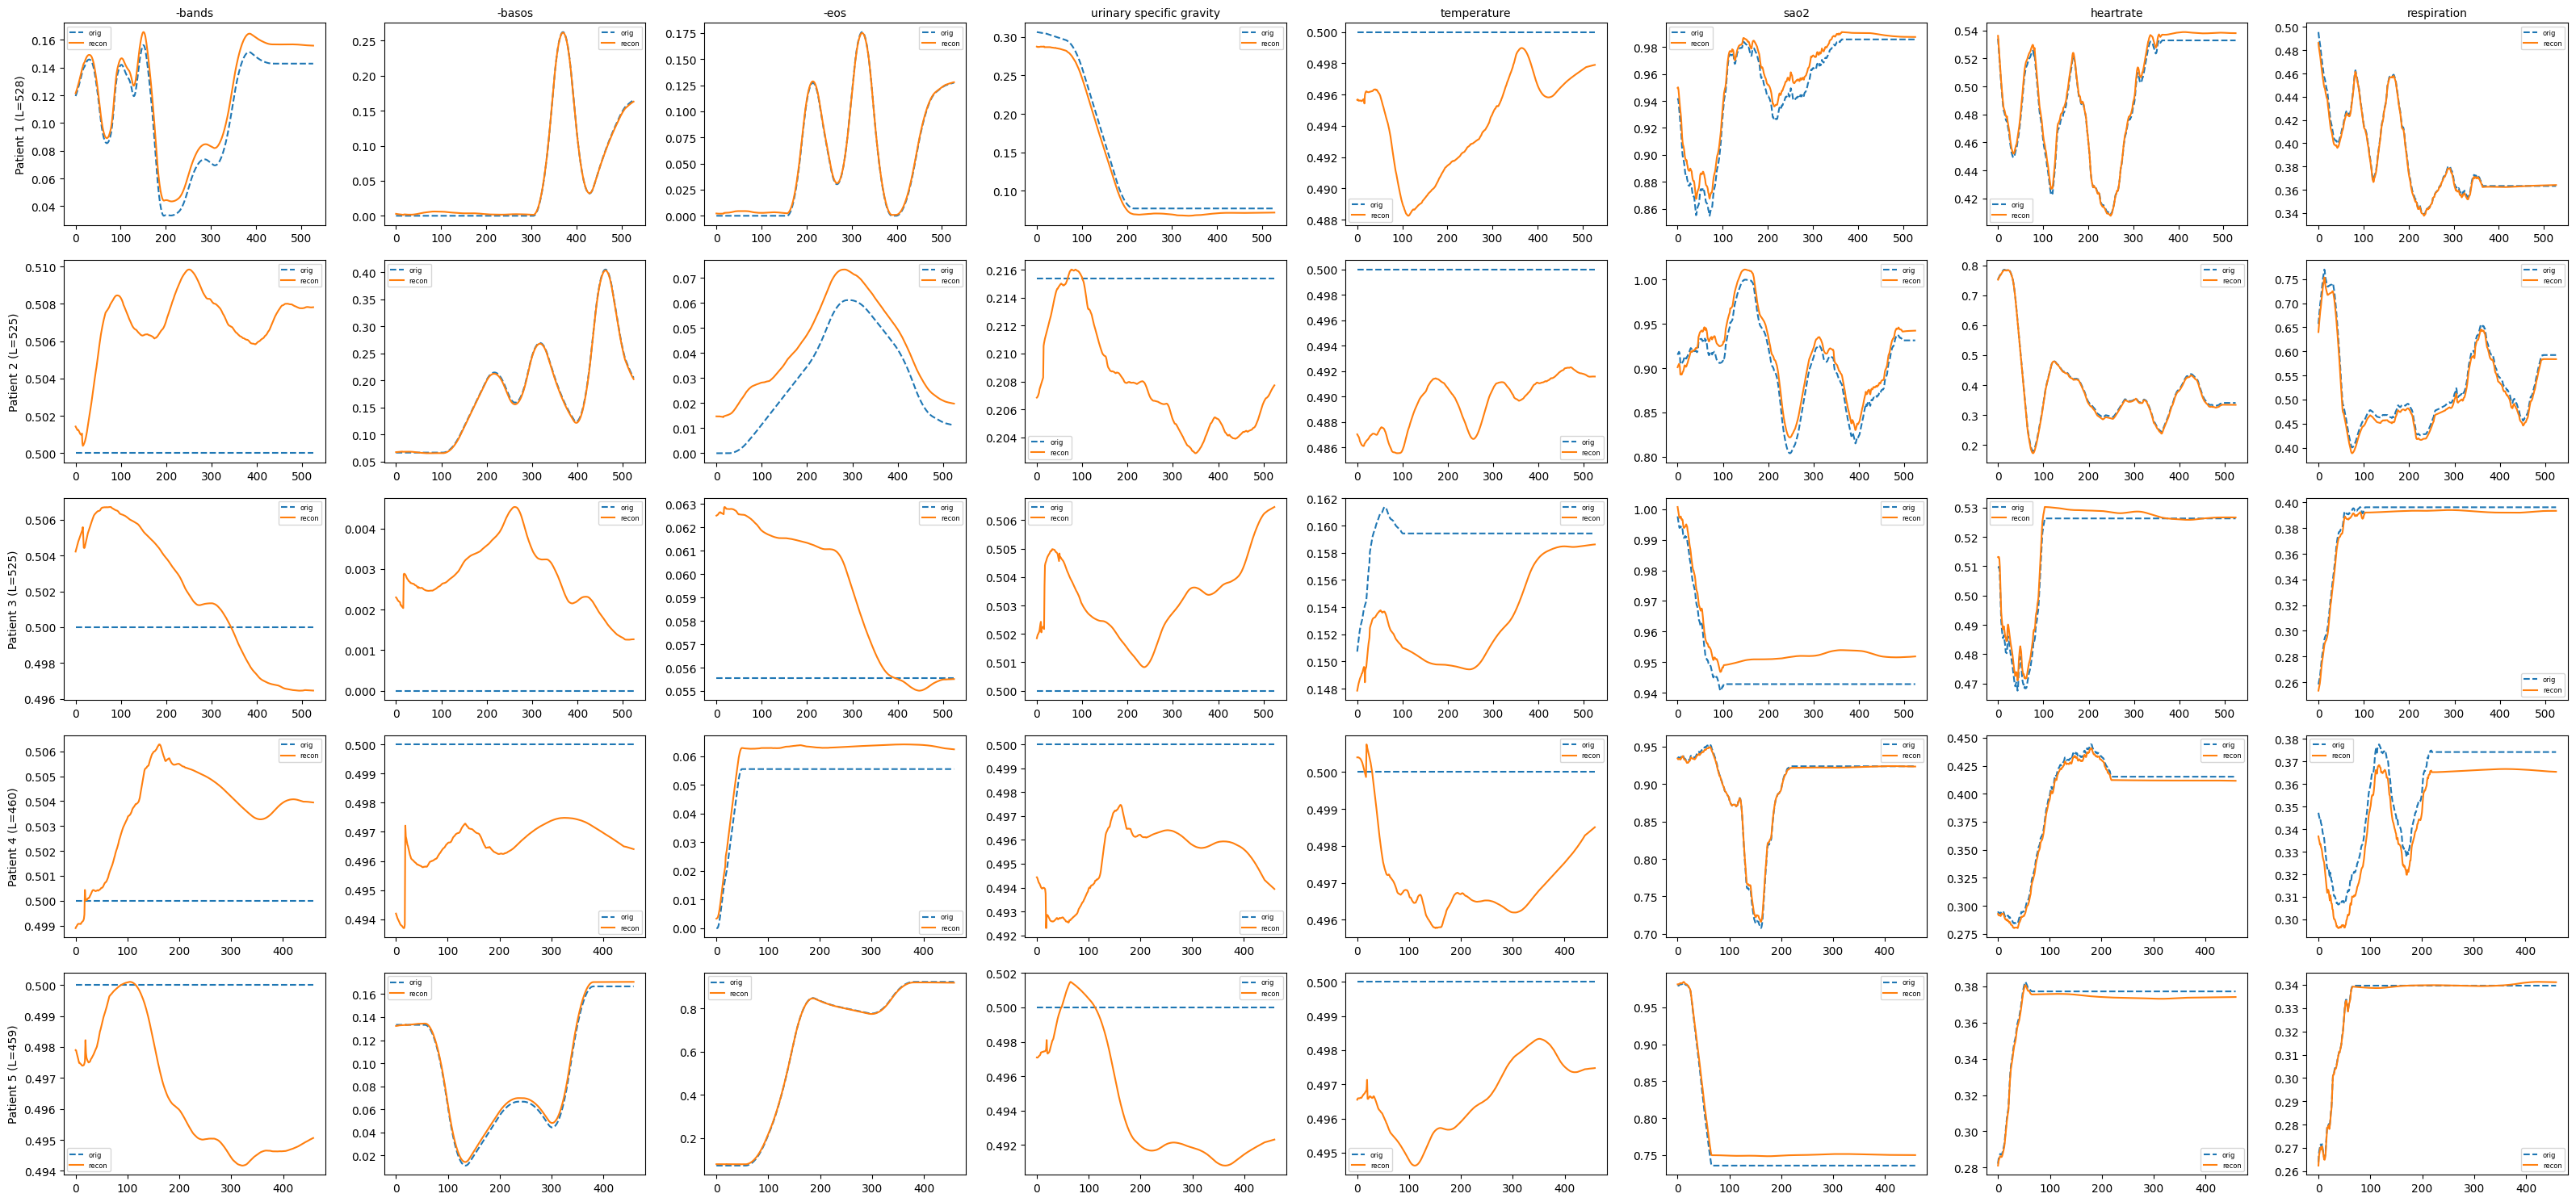

In [21]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 155503 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0104
  Std (overall): 0.2959
  Per-dim mean:
tensor([ 8.4174e-03,  7.3529e-03,  2.4470e-02,  2.0757e-03, -5.3646e-01,
        -1.6371e-02, -1.7308e-02,  1.0067e-02, -2.1717e-02, -1.7776e+00,
        -1.5325e-02,  1.0939e-03,  1.1844e-02,  3.0116e-02, -2.5057e-02,
        -4.1246e-02, -8.1754e-03, -4.5612e-03, -3.4930e-03, -8.0692e-03,
         1.4737e-02, -7.3740e-03, -8.3499e-03,  1.5437e-02, -1.6699e-01,
         9.3311e-03,  1.8826e-02,  1.5300e-01,  1.8939e-03,  2.8634e-02,
        -5.7377e-04,  4.6731e-03, -4.3247e-02,  2.1429e-02,  1.6252e-03,
         2.6677e-02,  1.9427e-03, -2.4276e-03,  1.7033e-03, -4.1983e-03,
         7.0751e-03, -2.5517e-02, -9.3196e-03, -1.5622e-02,  2.3439e-04,
         1.7230e-03, -2.7092e-02, -1.7469e-03, -1.6903e-02, -3.1055e-02,
        -6.5717e-03,  1.1638e-02, -7.0970e-03, -2.8615e-03,  7.5772e-03,
        -1.4162e-03, -2.4645e-03,  1

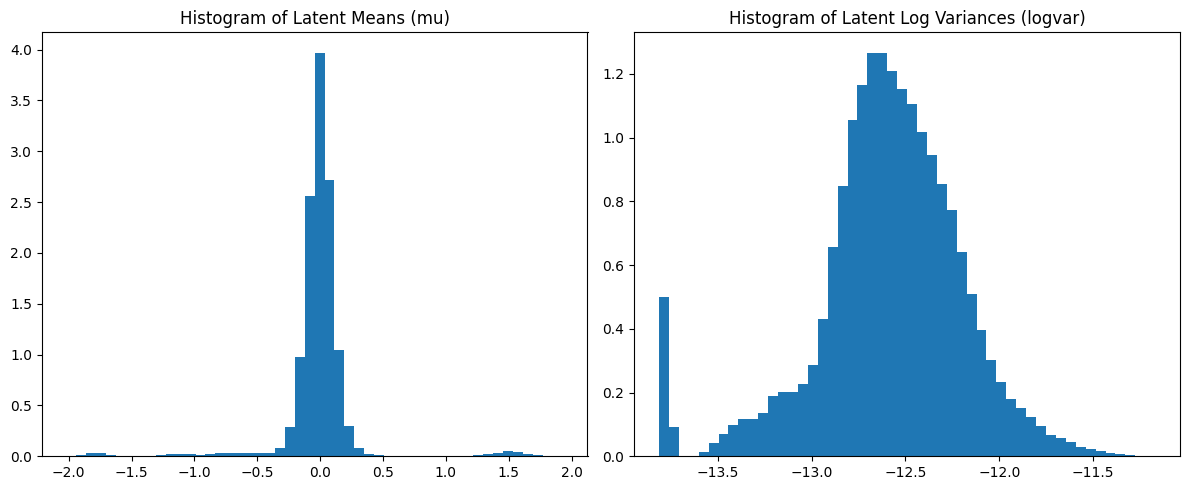

In [22]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stage3 = '/home/mei/nas/docker/thesis/data/model_results/retnet/resampled_30/stage3/best_joint.pth'
model3 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

In [6]:
from matplotlib.colors import LogNorm
def plot_som_activation_heatmap(heatmap, som_dim=(10,10), cmap="YlGnBu"):
    H, W = som_dim
    plt.figure(figsize=(W*0.6, H*0.6))
    sns.heatmap(
        heatmap,
        cmap=cmap,
        norm=LogNorm(vmin=max(heatmap.min(), 1e-3), vmax=heatmap.max()),
        annot=False,
        fmt="d",
        square=True,
        cbar_kws={"label": "Activation Count"}
    )
    plt.title("Overall SOM Activation")
    plt.xlabel("SOM Width")
    plt.ylabel("SOM Height")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

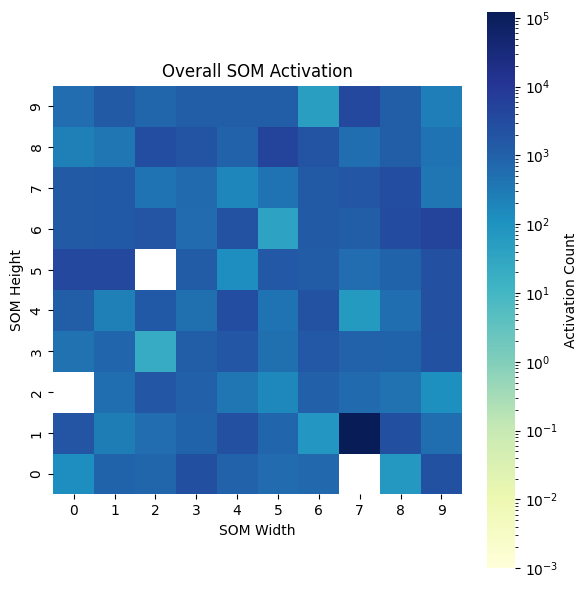

In [8]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device)
plot_som_activation_heatmap(activation_map)

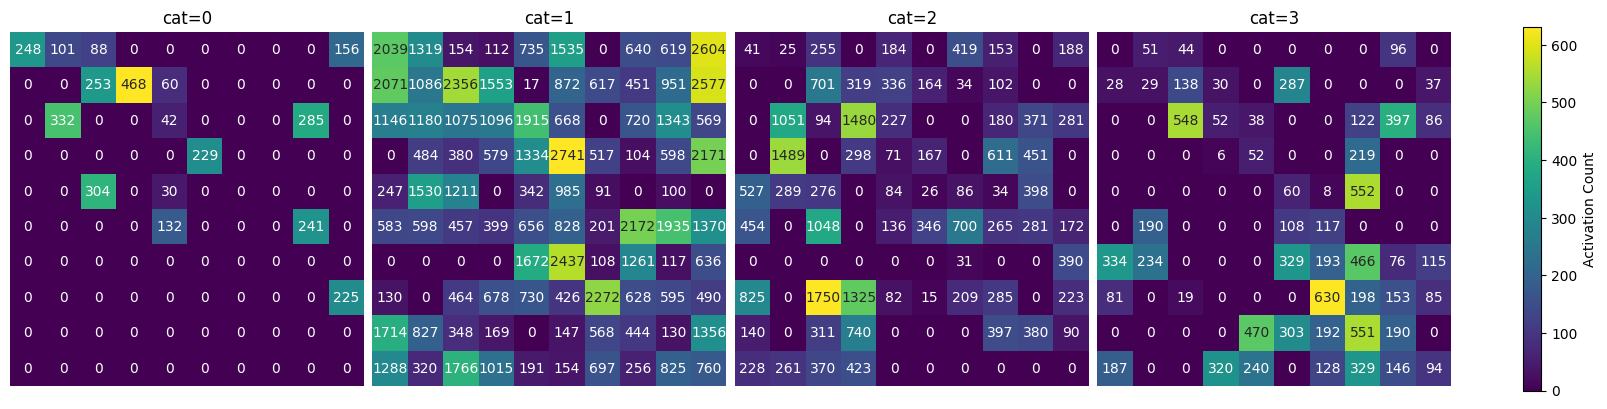

In [25]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

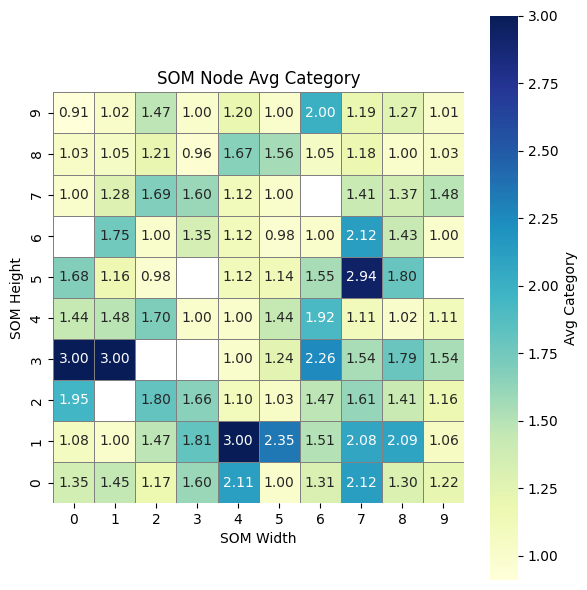

In [26]:

som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)